In [ ]:
#Grab Data
import yfinance as yf

#Usual Suspects
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

In [ ]:
#BTC/USDT price levels for the past 10 years
symbol = 'EUR=X'
raw = yf.download(symbol, start="2013-01-01", end="2023-02-28")['Adj Close']

data = pd.DataFrame(raw)

[*********************100%***********************]  1 of 1 completed


In [ ]:
data.head()

,Adj Close
Date,
2013-01-01,0.75750
2013-01-02,0.75770
2013-01-03,0.75860
2013-01-04,0.76730
2013-01-07,0.76526


In [ ]:
#Calculate the returns and add it to the DataFrame
data['return'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))

#When the market direction is greater than 0 --> classify 1, less than 0 --> 0
data['direction'] = np.where(data['return'] > 0, 1, 0)

data.head()

,Adj Close,return,direction
Date,,,
2013-01-01,0.75750,NaN,0
2013-01-02,0.75770,0.000264,1
2013-01-03,0.75860,0.001187,1
2013-01-04,0.76730,0.011403,1
2013-01-07,0.76526,-0.002662,0


In [ ]:
#Create 5 columns for each lag representing previous day's return
lags = 5

cols = []
for lag in range(1, lags + 1):
  col = f'lag_{lag}'
  data[col] = data['return'].shift(lag)
  cols.append(col)

data.dropna(inplace=True)

In [ ]:
data.round(4).tail()

,Adj Close,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,,,
2023-02-21,0.9361,0.0002,1,-0.0018,0.0024,0.0041,-0.0005,-0.0049
2023-02-22,0.9388,0.0029,1,0.0002,-0.0018,0.0024,0.0041,-0.0005
2023-02-23,0.9429,0.0043,1,0.0029,0.0002,-0.0018,0.0024,0.0041
2023-02-24,0.9436,0.0007,1,0.0043,0.0029,0.0002,-0.0018,0.0024
2023-02-27,0.9474,0.0041,1,0.0007,0.0043,0.0029,0.0002,-0.0018


# Deep Neural Network Stuff

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, RMSprop
import random

In [ ]:
optimizer = Adam(learning_rate=0.0001)

def set_seeds(seed=100):
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(100)

In [ ]:
set_seeds()
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(lags,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
train_set, test_set = np.split(data, [int(.70 *len(data))])

In [ ]:
mu, std = train_set.mean(), train_set.std()

In [ ]:
# Normalizes the features data by Gaussian normalization
training_data_ = (train_set - mu) / std
test_data_ = (test_set - mu) / std

In [ ]:
%%time
model.fit(train_set[cols],
           train_set['direction'],
           epochs=50, verbose=False,
           validation_split=0.2, shuffle=False)

CPU times: user 7.56 s, sys: 477 ms, total: 8.04 s
Wall time: 11 s


In [ ]:
res = pd.DataFrame(model.history.history)

<Axes: >

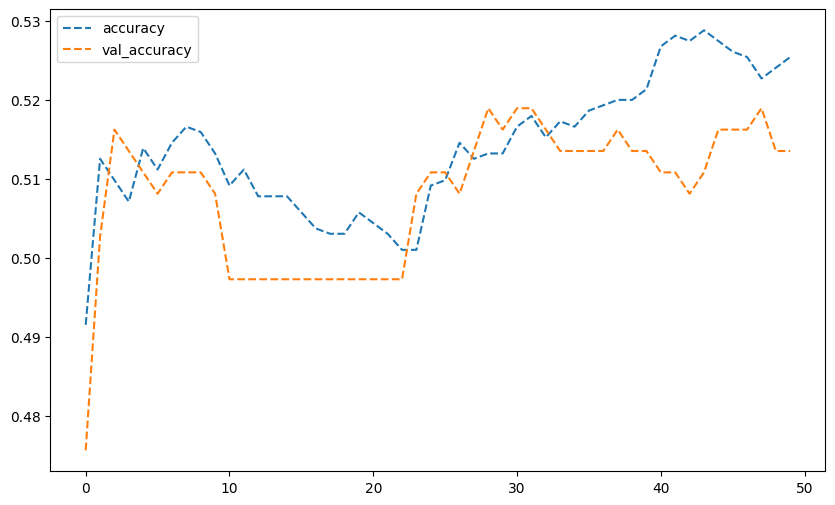

In [ ]:
# Accuracy of the model for training and validation in the training set
res[['accuracy', 'val_accuracy']].plot(figsize=(10,6), style='--')

In [ ]:
model.evaluate(training_data_[cols], train_set['direction'])

58/58 [==============================] - 0s 2ms/step - loss: 1.0081 - accuracy: 0.5181


[1.0081028938293457, 0.518137514591217]

In [ ]:
# Creating Prediction of market direction
pred = np.where(model.predict(training_data_[cols]) > 0.5, 1, 0)

58/58 [==============================] - 0s 1ms/step


In [ ]:
pred

In [ ]:
pred[:30].flatten()

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 0])

In [ ]:
# Transforming the predictions to long-short position; 1,-1
train_set['prediction'] = np.where(pred > 0, 1, -1)

In [ ]:
# Calculate strategy returns given the positions
train_set['strategy'] = (train_set['prediction'] * train_set['return'])

In [ ]:
train_set[['return', 'strategy']].sum().apply(np.exp)

return      1.201995
strategy    1.695248
dtype: float64

<Axes: xlabel='Date'>

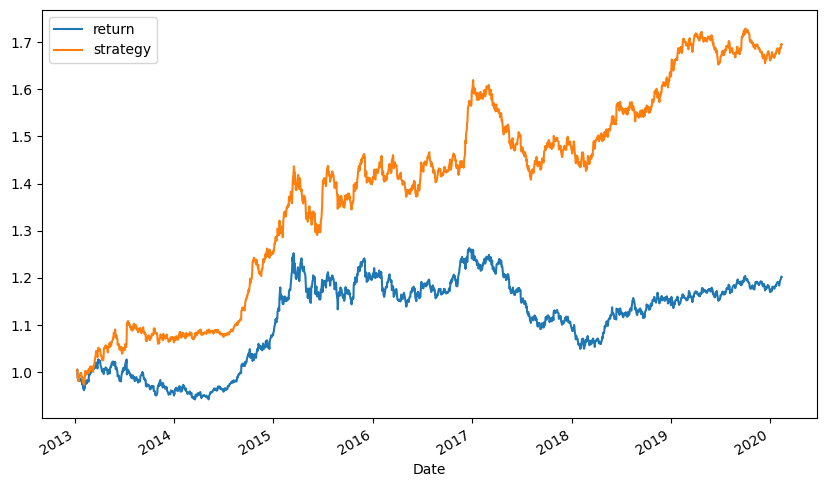

In [ ]:
# Plots the strategy returns to the benchmark performance for the sample
train_set[['return', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10,6))

# Same Process on the Out-of-Sample Test Set

In [ ]:
model.evaluate(test_data_[cols], test_set['direction'])

In [ ]:
pred = np.where(model.predict(test_data_[cols]) > 0.5, 1, 0)

25/25 [==============================] - 0s 1ms/step


In [ ]:
test_set['prediction'] = np.where(pred > 0, 1, -1)

In [ ]:
test_set['prediction'].value_counts()

 1    619
-1    174
Name: prediction, dtype: int64

In [ ]:
test_set['strategy'] = (test_set['prediction'] * test_set['return'])

In [ ]:
test_set[['return', 'strategy']].sum().apply(np.exp)

return      1.034549
strategy    0.842807
dtype: float64

<Axes: xlabel='Date'>

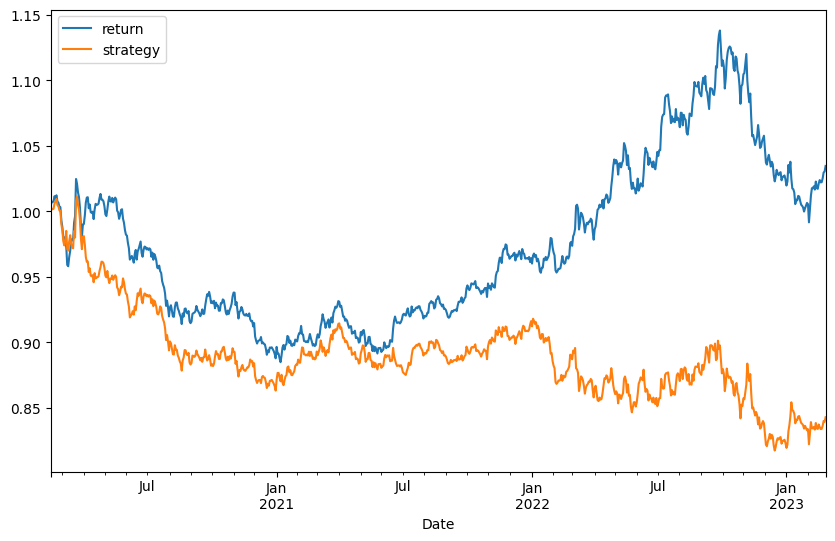

In [ ]:
test_set[['return', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10,6))

# Adding More Features

In [ ]:
#Add momentum, volatitlity, & distance to the data_frame
data['momentum'] = data['return'].rolling(5).mean().shift(1)
data['volatility'] = data['return'].rolling(20).std().shift(1)
data['distance'] = (data['Adj Close'] - data['Adj Close'].rolling(50).mean()).shift(1)

In [ ]:
data.dropna(inplace=True)

In [ ]:
cols.extend(['momentum', 'volatility', 'distance'])

In [ ]:
# New DataFrame
data.round(4).tail()

,Adj Close,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5,momentum,volatility,distance
Date,,,,,,,,,,,
2023-02-21,0.9361,0.0002,1,-0.0018,0.0024,0.0041,-0.0005,-0.0049,-0.0001,0.0053,0.0039
2023-02-22,0.9388,0.0029,1,0.0002,-0.0018,0.0024,0.0041,-0.0005,0.0009,0.0053,0.0043
2023-02-23,0.9429,0.0043,1,0.0029,0.0002,-0.0018,0.0024,0.0041,0.0016,0.0053,0.0070
2023-02-24,0.9436,0.0007,1,0.0043,0.0029,0.0002,-0.0018,0.0024,0.0016,0.0053,0.0110
2023-02-27,0.9474,0.0041,1,0.0007,0.0043,0.0029,0.0002,-0.0018,0.0013,0.0053,0.0116


In [ ]:
# Refit and train/test
train_data, test_data = np.split(data, [int(.70 *len(data))])
mu, std = train_data.mean(), train_data.std()

In [ ]:
training_data_ = (train_data - mu) / std
test_data_ = (test_data - mu) / std

In [ ]:
# Update Dense Layers to 32
set_seeds()
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(len(cols),)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
%%time
model.fit(training_data_[cols],
           train_data['direction'],
           epochs=25, verbose=False,
           validation_split=0.2, shuffle=False)

CPU times: user 4.04 s, sys: 218 ms, total: 4.26 s
Wall time: 3.79 s


In [ ]:
model.evaluate(training_data_[cols], train_data['direction'])

57/57 [==============================] - 0s 2ms/step - loss: 0.6822 - accuracy: 0.5568


[0.6822247505187988, 0.5568432807922363]

In [ ]:
pred = np.where(model.predict(training_data_[cols]) > 0.5, 1, 0)

57/57 [==============================] - 0s 2ms/step


In [ ]:
train_data['prediction'] = np.where(pred > 0, 1, -1)

In [ ]:
train_data['strategy'] = (train_data['prediction'] * train_data['return'])

In [ ]:
train_data[['return', 'strategy']].sum().apply(np.exp)

return      1.157799
strategy    2.241923
dtype: float64

<Axes: xlabel='Date'>

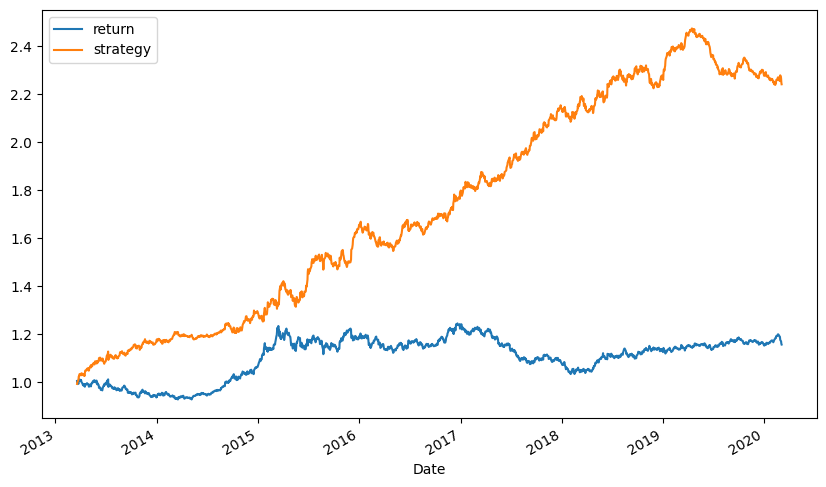

In [ ]:
train_data[['return', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10,6))

With additional features we see significantly better results, but let's test it against the out-of-sample test set

## Test Set Prediction

In [ ]:
model.evaluate(test_data_[cols], test_data['direction'])

25/25 [==============================] - 0s 2ms/step - loss: 0.7038 - accuracy: 0.4974


[0.7037815451622009, 0.4974293112754822]

In [ ]:
pred = np.where(model.predict(test_data_[cols]) > 0.5, 1, 0)

25/25 [==============================] - 0s 1ms/step


In [ ]:
test_data['prediction'] = np.where(pred > 0, 1, -1)

In [ ]:
test_set['prediction'].value_counts()

 1    619
-1    174
Name: prediction, dtype: int64

In [ ]:
test_set['strategy'] = (test_set['prediction'] * test_set['return'])

In [ ]:
test_set[['return', 'strategy']].sum().apply(np.exp)

return      1.034549
strategy    0.842807
dtype: float64

<Axes: xlabel='Date'>

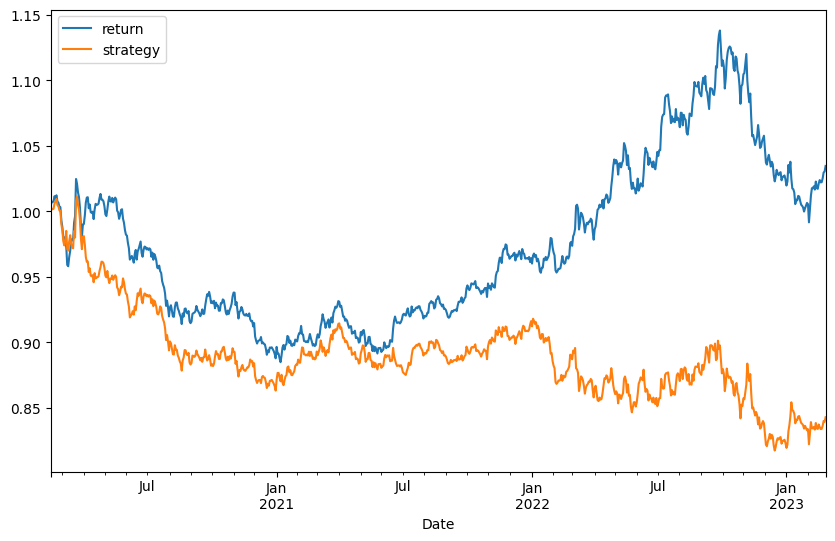

In [ ]:
test_set[['return', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10,6))